In [107]:
from importlib import reload
import methods
import warnings
import pickle

import pandas as pd

In [103]:
reload(methods)
from methods import *

In [58]:
#get the list of proteins names from the 'pdb' directory of protein structures

directory = 'pdb'
filenames = get_files_with_ext(directory, '.pdb')
protlist = [os.path.splitext(file)[0] for file in filenames]

In [78]:
#save plot of regression for each protein and save LRR annotation start/end into the dictionary cutoff_d. plot_regression returns standard deviation of middle line segment in regression.
cutoff_d = {}
std_d = {}
for protid in protlist:
    preX = get_backbone_from_pdb(f'pdb/{protid}.pdb')
    winding, m, parameters = get_regression(preX)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        stddev = plot_regression(winding, parameters, m, save = True, filename = f'plot/regression/{protid}')
        std_d[protid] = stddev
        cutoff_d[protid] = tuple(parameters.astype('int'))

with open('pickles/cutoff_d.pickle', 'wb') as handle:
    pickle.dump(cutoff_d, handle)
with open('pickles/std_d.pickle', 'wb') as handle:
    pickle.dump(std_d, handle)    

In [ ]:
'''alternative to previous cell: load dictionary from pickles'''

# with open('pickles/cutoff_d.pickle', 'rb') as handle:
#     cutoff_d = pickle.load(handle)    
# with open('pickles/std_d.pickle', 'rb') as handle:
#     std_d = pickle.load(handle)    

(array([17., 19., 33., 14., 15., 14., 13., 10., 11.,  4.,  6.,  2.,  3.,
         1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.0491697 , 0.09330121, 0.13743271, 0.18156422, 0.22569573,
        0.26982724, 0.31395875, 0.35809026, 0.40222176, 0.44635327,
        0.49048478, 0.53461629, 0.5787478 , 0.6228793 , 0.66701081,
        0.71114232, 0.75527383, 0.79940534, 0.84353685, 0.88766835,
        0.93179986, 0.97593137, 1.02006288, 1.06419439, 1.10832589,
        1.1524574 , 1.19658891, 1.24072042, 1.28485193, 1.32898343,
        1.37311494, 1.41724645, 1.46137796, 1.50550947, 1.54964098,
        1.59377248, 1.63790399, 1.6820355 , 1.72616701, 1.77029852,
        1.81443002, 1.85856153, 1.90269304, 1.94682455, 1.99095606,
        2.03508757, 2.07921907, 2.12335058, 2.16748209, 2.2116136 ,
        2.25574511]),
 <BarContainer

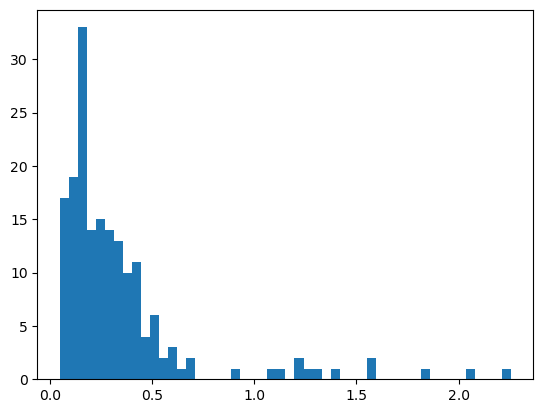

In [81]:
#visualize distribution of standard deviations to determine which regressions turned out badly and require multi-breakpoint
plt.hist(list(std_d.values()), bins = 50)

In [105]:
#run 4-breakpoint regression and save plots folder
multi_parameters = {}
for protid in protlist:
    if std_d[protid] > .7:
        preX = get_backbone_from_pdb(f'pdb/{protid}.pdb')
        a, b = cutoff_d[protid]
        winding, m, parameters = multi_regression(preX, a, b)
        plot_regression_multi(winding, parameters, m, filename = f'plot/piecewise_multi/{protid}', save = True)
# with open('pickles/multi_parameters.pickle', 'wb') as handle:
#     pickle.dump(multi_parameters, handle)

In [111]:
#collect lrrpredictor outputs into a dictionary
df = pd.read_csv('LRRPredictor_output/col-0-nlrome.txt', delimiter = '\t')
motifs_d = {}
for protid in protlist:
    motifs = []
    foundProtein = False
    for ii in range(len(df)):
        if '.'.join(df['annotation'][ii].split('_')[1:]) == protid:
            foundProtein = True
        elif foundProtein:            
            break
        if foundProtein:
            motifs.append(int(df['start'][ii]))
    motifs_d[protid] = motifs

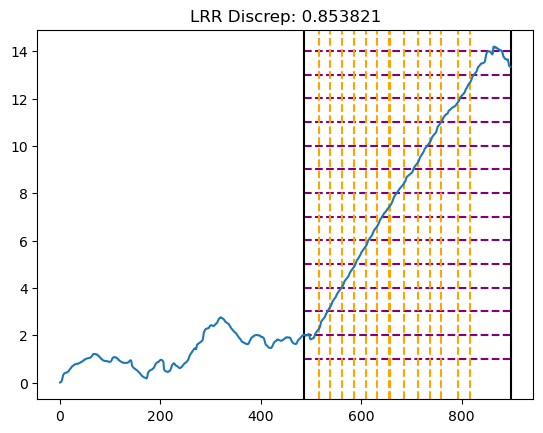

In [119]:
protid = 'AT1G63350.1'

preX = get_backbone_from_pdb(f'pdb/{protid}.pdb')

winding, s, c, q, dx = get_winding(preX)
a, b = cutoff_d[protid]

verticals = np.array([p for p in motifs_d[protid] if a <= p <= b])
lrr_heights = winding[verticals]
k = len(lrr_heights)

u = 1 + np.zeros(k)
v = np.arange(0.0, k)

v -= (u @ v) / (u @ u) * u
z = (lrr_heights @ u) / (u @ u) * u + (lrr_heights @ v) / (v @ v) * v
diff = np.sign(np.mean(z[1:] - z[:-1]))
projected = diff * v + (z @ u) / (u @ u) * u
discrep = np.mean((projected - lrr_heights) ** 2)
# hs = np.arange(int(min(winding[a:b])) + g, int(max(winding[a:b]))) + g
hs = projected
# vs = np.array(motifs_d[protid])
vs = np.array(verticals)
ext_vs = set(motifs_d[protid]) - set(vs)
# plt.hlines(hs, xmin = a, xmax = b, color = 'purple', ls = '--')
plt.hlines(projected, xmin = a, xmax = b, color = 'purple', ls = '--')

for vert in vs:
    plt.axvline(vert, color = 'orange', ls = '--')
for vert in ext_vs:
    plt.axvline(vert, color = 'red', ls = '--')
    
plt.axvline(a, color = 'black')
plt.axvline(b, color = 'black')
plt.plot(winding)
plt.title(f'LRR Discrep: {discrep:.6}')
plt.show()
